# Machine Learning example on _1 billion_ samples: N. Y. CityCabs data

### Predict the likely duration of a taxi trip

In [1]:
import vaex
import vaex.ml

import numpy as np

import pylab as plt

import warnings
warnings.filterwarnings("ignore")

### Adjusting `matplotlib` parameters

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Read in the data

- Can "read" the memmory mapped file that we have on disk in no time.
- `Vaex` can also read data stored on S3. The data is streamed on a need-to-have basis and is locally cached.

In [3]:
# Check the file size on disk
!ls -l -h ./data/yellow_taxi_2009_2015_f32.hdf5

-rw-r--r--  1 jovan  staff   107G Jul  3  2019 ./data/yellow_taxi_2009_2015_f32.hdf5


In [4]:
# Read in the data from disk
df = vaex.open('./data/yellow_taxi_2009_2015_f32.hdf5')

# # Alternatively, one can read in the data straight from AWS
# df = vaex.open('s3://vaex/taxi/yellow_taxi_2009_2015_f32.hdf5?anon=true')

Opening a DataFrame straight from S3 will lazily download the data. Given the large quantity of data used in this notebook, this might disrupt ones workflow. Thus it may be more convenient to simply pre-fetch the relevant portions of the data prior to doing any work.

In [ ]:
# One can also take a smaller subset of the data
# df = df[:10_000_000]  

# used_columns = """dropoff_datetime pickup_datetime
#                   trip_distance passenger_count
#                   pickup_longitude pickup_latitude
#                   dropoff_longitude
#                   dropoff_latitude
#                   """.split()
# for col in used_columns:
#     df.nop(col, progress='widget')

In [5]:
# Inspect the data
df

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,VTS,2009-01-04 02:52:00.000000000,2009-01-04 03:02:00.000000000,1,CASH,2.630000114440918,-73.99195861816406,40.72156524658203,nan,nan,-73.99380493164062,40.6959228515625,8.899999618530273,0.5,nan,0.0,0.0,9.399999618530273
1,VTS,2009-01-04 03:31:00.000000000,2009-01-04 03:38:00.000000000,3,Credit,4.550000190734863,-73.98210144042969,40.736289978027344,nan,nan,-73.95584869384766,40.768028259277344,12.100000381469727,0.5,nan,2.0,0.0,14.600000381469727
2,VTS,2009-01-03 15:43:00.000000000,2009-01-03 15:57:00.000000000,5,Credit,10.350000381469727,-74.0025863647461,40.73974609375,nan,nan,-73.86997985839844,40.770225524902344,23.700000762939453,0.0,nan,4.739999771118164,0.0,28.440000534057617
3,DDS,2009-01-01 20:52:58.000000000,2009-01-01 21:14:00.000000000,1,CREDIT,5.0,-73.9742660522461,40.79095458984375,nan,nan,-73.9965591430664,40.731849670410156,14.899999618530273,0.5,nan,3.049999952316284,0.0,18.450000762939453
4,DDS,2009-01-24 16:18:23.000000000,2009-01-24 16:24:56.000000000,1,CASH,0.4000000059604645,-74.00157928466797,40.719383239746094,nan,nan,-74.00837707519531,40.7203483581543,3.700000047683716,0.0,nan,0.0,0.0,3.700000047683716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,173,057,922",VTS,2015-12-31 23:59:56.000000000,2016-01-01 00:08:18.000000000,5,1,1.2000000476837158,-73.99381256103516,40.72087097167969,1.0,0.0,-73.98621368408203,40.722469329833984,7.5,0.5,0.5,1.7599999904632568,0.0,10.5600004196167
"1,173,057,923",CMT,2015-12-31 23:59:58.000000000,2016-01-01 00:05:19.000000000,2,2,2.0,-73.96527099609375,40.76028060913086,1.0,0.0,-73.93951416015625,40.75238800048828,7.5,0.5,0.5,0.0,0.0,8.800000190734863
"1,173,057,924",CMT,2015-12-31 23:59:59.000000000,2016-01-01 00:12:55.000000000,2,2,3.799999952316284,-73.98729705810547,40.739078521728516,1.0,0.0,-73.9886703491211,40.69329833984375,13.5,0.5,0.5,0.0,0.0,14.800000190734863
"1,173,057,925",VTS,2015-12-31 23:59:59.000000000,2016-01-01 00:10:26.000000000,1,2,1.9600000381469727,-73.99755859375,40.72569274902344,1.0,0.0,-74.01712036132812,40.705322265625,8.5,0.5,0.5,0.0,0.0,9.800000190734863


### Split the data into train & test sets

- All data prior to 2015 is train;
- All data of 2015 is test.

In [6]:
# Train / test split (by date, data is ordered by year)
df_train = df[:1_026_944_937]
df_test = df[1_026_944_937:]
df_test_prod = df_test.copy() # For an in-production scenario example

print(f'Number of samples in the training set: {len(df_train):,}')
print(f'Number of samples in the test set:       {len(df_test):,}')

# Check if the lengths of the datasets match
assert len(df) == len(df_test) + len(df_train)

Number of samples in the training set: 1,026,944,937
Number of samples in the test set:       146,112,990


### Initial feature generation
 - create tha target variable: "trip_duration_min" (duration of the taxi trips in minutes)
 - the mean speed of the trip: "trip_speed_mph" (in miles per hour, useful for cleaning spurious samples)

In [7]:
# Time in transit (minutes) - This is the target variable
df_train['trip_duration_min'] = (df_train.dropoff_datetime - df_train.pickup_datetime) / \
                                   np.timedelta64(1, 'm')

In [8]:
# Speed (miles per hour) - To be used for cleaning of the training data
df_train['trip_speed_mph'] = df_train.trip_distance / \
                                ((df_train.dropoff_datetime - df_train.pickup_datetime) / \
                                np.timedelta64(1, 'h'))

### Data cleaning

- To get better insight into why the data has been cleaned in this way, please check [this Notebook](https://nbviewer.jupyter.org/github/vaexio/vaex-examples/blob/master/medium-nyc-taxi-data-eda/vaex-taxi-article.ipynb).

In [9]:
# Filter abnormal number of passengers
df_train = df_train[(df_train.passenger_count>0) & (df_train.passenger_count<7)]

# Select taxi trips have travelled maximum 7 miles (but also with non-zero distance).
df_train = df_train[(df_train.trip_distance > 0) & (df_train.trip_distance < 7)]

# Filter taxi trips that have durations longer than 25 minutes or that lasted less than 3 minutes
df_train = df_train[(df_train.trip_duration_min > 3) & (df_train.trip_duration_min < 25)]

# Filter out errouneous average trip speeds.
df_train = df_train[(df_train.trip_speed_mph > 1) & (df_train.trip_speed_mph < 60)]

# Define the NYC boundaries
long_min = -74.05
long_max = -73.75
lat_min = 40.58
lat_max = 40.90

# Make a selection based on the boundaries
df_train = df_train[(df_train.pickup_longitude > long_min)  & (df_train.pickup_longitude < long_max) & \
                    (df_train.pickup_latitude > lat_min)    & (df_train.pickup_latitude < lat_max) & \
                    (df_train.dropoff_longitude > long_min) & (df_train.dropoff_longitude < long_max) & \
                    (df_train.dropoff_latitude > lat_min)   & (df_train.dropoff_latitude < lat_max)]

# If there are unknown (N/A) pick-up or drop-off locations, choose a representative value. 
df_train['dropoff_latitude'] = df_train.dropoff_latitude.fillna(value=40.76)
df_train['pickup_latitude'] = df_train.pickup_latitude.fillna(value=40.76)

df_train['dropoff_longitude'] = df_train.dropoff_longitude.fillna(value=-73.99)
df_train['pickup_longitude'] = df_train.pickup_longitude.fillna(value=-73.99)

### Create some additional features:
 - feature: the pickup time
 - feature: the pickup day
 - feature: the pickup month
 - feature: is the pickup on a weekend
 - feature: "as the crow" files distance between the pickup and the dropoff location
 - feature: the direction angle from the pickup to the dropoff location

In [10]:
# Pickup datetime features
df_train['pickup_time'] = df_train.pickup_datetime.dt.hour + df_train.pickup_datetime.dt.minute / 60.
df_train['pickup_day'] = df_train.pickup_datetime.dt.dayofweek
df_train['pickup_month'] = df_train.pickup_datetime.dt.month - 1 # so it starts from 0
df_train['pickup_is_weekend'] = (df_train.pickup_day>=5).astype('int')

In [11]:
# Arc distance  in miles
def arc_distance(theta_1, phi_1, theta_2, phi_2):
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    distance = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return distance * 3958.8

# Create the feature
df_train['arc_distance'] = arc_distance(df_train.pickup_longitude, 
                                        df_train.pickup_latitude, 
                                        df_train.dropoff_longitude, 
                                        df_train.dropoff_latitude).jit_numba()

In [12]:
# Direction of travel in degrees
def direction_angle(theta_1, phi_1, theta_2, phi_2):
    dtheta = theta_2 - theta_1
    dphi = phi_2 - phi_1
    radians = np.arctan2(dtheta, dphi)
    return np.rad2deg(radians)

# Create the feature
df_train['direction_angle'] = direction_angle(df_train.pickup_longitude, 
                                              df_train.pickup_latitude, 
                                              df_train.dropoff_longitude, 
                                              df_train.dropoff_latitude).jit_numba()

Review the newly created features, and at the same time evaluate created filters.

In [13]:
# Get a preview of the training data
df_train

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,trip_duration_min,trip_speed_mph,pickup_time,pickup_day,pickup_month,pickup_is_weekend,arc_distance,direction_angle
0,VTS,2009-01-04 02:52:00.000000000,2009-01-04 03:02:00.000000000,1,CASH,2.630000114440918,-73.99195861816406,40.72156524658203,nan,nan,-73.99380493164062,40.6959228515625,8.899999618530273,0.5,nan,0.0,0.0,9.399999618530273,10.0,15.780000686645508,2.8666666666666667,6,0,1,0.5049489140510559,-175.88168334960938
1,VTS,2009-01-04 03:31:00.000000000,2009-01-04 03:38:00.000000000,3,Credit,4.550000190734863,-73.98210144042969,40.736289978027344,nan,nan,-73.95584869384766,40.768028259277344,12.100000381469727,0.5,nan,2.0,0.0,14.600000381469727,7.0,39.00000163487026,3.5166666666666666,6,0,1,1.9123317003250122,39.596309661865234
2,DDS,2009-01-01 20:52:58.000000000,2009-01-01 21:14:00.000000000,1,CREDIT,5.0,-73.9742660522461,40.79095458984375,nan,nan,-73.9965591430664,40.731849670410156,14.899999618530273,0.5,nan,3.049999952316284,0.0,18.450000762939453,21.033333333333335,14.263074484944532,20.866666666666667,3,0,0,1.9083821773529053,-159.33460998535156
3,DDS,2009-01-24 16:18:23.000000000,2009-01-24 16:24:56.000000000,1,CASH,0.4000000059604645,-74.00157928466797,40.719383239746094,nan,nan,-74.00837707519531,40.7203483581543,3.700000047683716,0.0,nan,0.0,0.0,3.700000047683716,6.55,3.664122192004255,16.3,5,0,1,0.4700464904308319,-81.91941833496094
4,DDS,2009-01-16 22:35:59.000000000,2009-01-16 22:43:35.000000000,2,CASH,1.2000000476837158,-73.98980712890625,40.73500442504883,nan,nan,-73.98502349853516,40.72449493408203,6.099999904632568,0.5,nan,0.0,0.0,6.599999904632568,7.6,9.473684586976702,22.583333333333332,4,0,0,0.3864792585372925,155.52627563476562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"812,816,590",VTS,2014-12-15 19:11:00.000000000,2014-12-15 19:17:00.000000000,6,CSH,0.5899999737739563,-73.9603500366211,40.76624298095703,1.0,nan,-73.96752166748047,40.76290512084961,5.5,1.0,0.5,0.0,0.0,7.0,6.0,5.899999737739563,19.183333333333334,0,11,0,0.49959608912467957,-114.95848083496094
"812,816,591",VTS,2014-12-15 18:53:00.000000000,2014-12-15 19:15:00.000000000,1,CRD,3.0,-73.98713684082031,40.73884201049805,1.0,nan,-73.9609375,40.77593994140625,15.5,1.0,0.5,1.0,0.0,18.0,22.0,8.181818181818182,18.883333333333333,0,11,0,1.943618893623352,35.23054504394531
"812,816,592",VTS,2014-12-15 19:20:00.000000000,2014-12-15 19:25:00.000000000,2,CSH,0.6600000262260437,-73.95462799072266,40.77800750732422,1.0,nan,-73.96318817138672,40.776947021484375,5.0,1.0,0.5,0.0,0.0,6.5,5.0,7.920000314712524,19.333333333333332,0,11,0,0.5918043851852417,-97.0621566772461
"812,816,593",VTS,2014-12-16 01:45:00.000000000,2014-12-16 01:54:00.000000000,1,CRD,2.680000066757202,-73.9609603881836,40.79698944091797,1.0,nan,-73.98635864257812,40.76822280883789,10.0,0.5,0.5,2.619999885559082,0.0,13.619999885559082,9.0,17.866667111714683,1.75,1,11,0,1.838662028312683,-138.55850219726562


### Transform features: PCA of the pick-up and drop-off locations

In [14]:
# PCA of the pickup and dropoff locations - helps to "straighten out" the coordinates

# pickup transformations
pca_pickup = vaex.ml.PCA(features=['pickup_longitude', 'pickup_latitude'], n_components=2, prefix='PCA_pickup_')
df_train = pca_pickup.fit_transform(df_train)

# dropoff transformations
pca_dropoff = vaex.ml.PCA(features=['dropoff_longitude', 'dropoff_latitude'], n_components=2, prefix='PCA_dropoff_')
df_train = pca_dropoff.fit_transform(df_train)

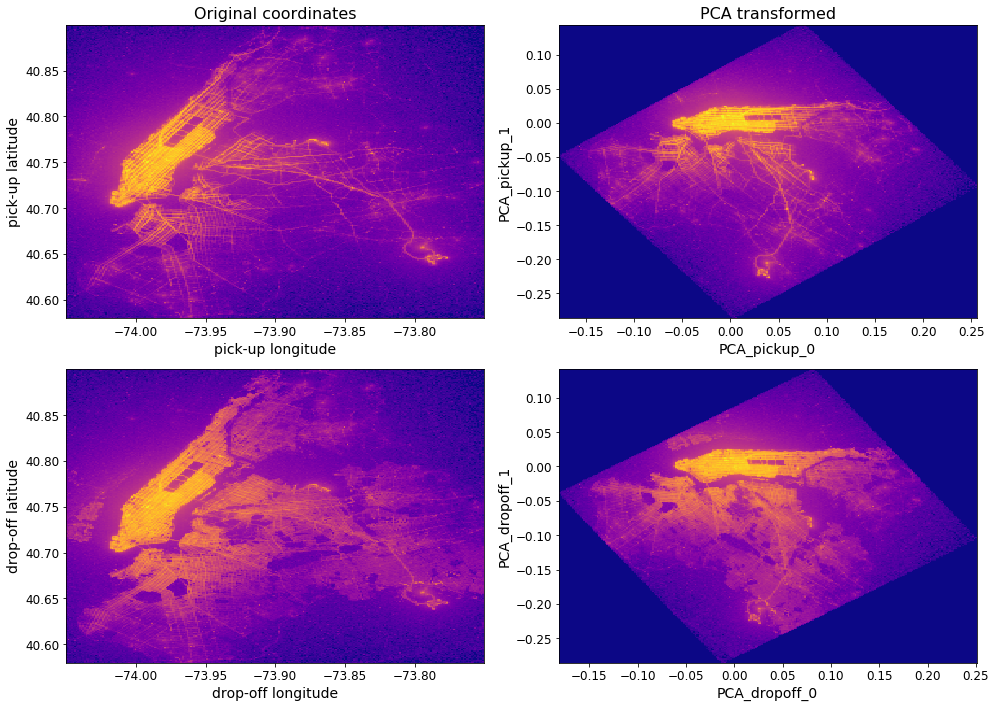

In [15]:
# Visualise the PCA results to make sure they makes sense
plt.figure(figsize=(14, 10))

plt.subplot(221)
plt.title('Original coordinates', fontsize=16)
df_train.plot(df_train.pickup_longitude, df_train.pickup_latitude,
              limits='minmax', f='log1p', shape=256,
              colormap='plasma', colorbar=False, 
              xlabel='pick-up longitude', ylabel='pick-up latitude')

plt.subplot(222)
plt.title('PCA transformed', fontsize=16)
df_train.plot(df_train.PCA_pickup_0, df_train.PCA_pickup_1,
              limits='minmax', f='log1p', shape=256,
              colormap='plasma', colorbar=False,
              xlabel='PCA_pickup_0', ylabel='PCA_pickup_1')
              

plt.subplot(223)
df_train.plot(df_train.dropoff_longitude, df_train.dropoff_latitude,
              limits='minmax', f='log1p', shape=256,
              colormap='plasma', colorbar=False,
              xlabel='drop-off longitude', ylabel='drop-off latitude')

plt.subplot(224)
df_train.plot(df_train.PCA_dropoff_0, df_train.PCA_dropoff_1,
              limits='minmax', f='log1p', shape=256,
              colormap='plasma', colorbar=False,
              xlabel='PCA_dropoff_0', ylabel='PCA_dropoff_1')

plt.tight_layout()
plt.show()

### Handling temporal (cyclical) features
 - Assume the temporal feature is the $\theta$ coordinate of a unit circle in polar coordinates. Conver it to Cartesian $(x, y)$ coordinates. This preserves the continuity (12 o'clock is close to 1 o'clock).

In [16]:
# Time
cycl_transform_time = vaex.ml.CycleTransformer(features=['pickup_time'], n=24)
df_train = cycl_transform_time.fit_transform(df_train)

# Day
cycl_transform_day = vaex.ml.CycleTransformer(features=['pickup_day'], n=7)
df_train = cycl_transform_day.fit_transform(df_train)

# Month
cycl_transform_month = vaex.ml.CycleTransformer(features=['pickup_month'], n=12)
df_train = cycl_transform_month.fit_transform(df_train)

# Direction angle
cycl_transform_angle = vaex.ml.CycleTransformer(features=['direction_angle'], n=360)
df_train = cycl_transform_angle.fit_transform(df_train)

To make sure that the above transformations make sense, let's plot the transformed coordinates for the pickup_time feature.

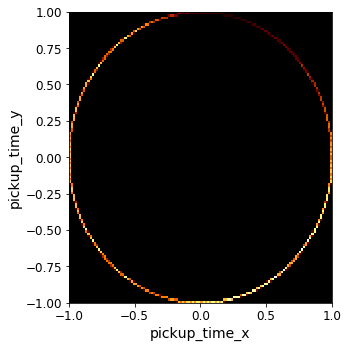

In [17]:
# Let's see how the transformed date would look like
df_train.plot(x='pickup_time_x', y='pickup_time_y', 
              shape=128, limits=[-1, 1],
              figsize=(5, 5),
              colorbar=False)
plt.show()

Note that unlike a regular wall clock, all 24 hours are represented on the circle below. So in this case:
    - "midnight" has coordinates (x, y) = (1, 0)
    - "6 o'clock" has coordinates (x, y) = (0, 1)

### Scaling of numerical features

In [18]:
# Standard scaling of numerical features
standard_scaler = vaex.ml.StandardScaler(features=['arc_distance'])
df_train = standard_scaler.fit_transform(df_train)

### Preview the training features

In [19]:
# Select all the features to be used for training the model
features = df_train.get_column_names(regex='PCA*') + \
           df_train.get_column_names(regex='standard_scaled_*') + \
           df_train.get_column_names(regex='.*_x') + \
           df_train.get_column_names(regex='.*_y') + \
           ['pickup_is_weekend']

# Preview the features
df_train.head(10)[features]

#,PCA_pickup_0,PCA_pickup_1,PCA_dropoff_0,PCA_dropoff_1,standard_scaled_arc_distance,pickup_time_x,pickup_day_x,pickup_month_x,direction_angle_x,pickup_time_y,pickup_day_y,pickup_month_y,direction_angle_y,pickup_is_weekend
0,-0.0309687,-0.00923445,-0.0549368,-0.0194697,-0.723864,0.731354,0.62349,1,-0.997418,0.681998,-0.781831,0,-0.071816,1
1,-0.0132836,-0.00813007,0.0260018,-0.0100453,0.846021,0.605294,0.62349,1,0.770554,0.796002,-0.781831,0,0.637374,1
2,0.0349145,0.0188245,-0.0268506,0.00310216,0.841615,0.681998,-0.900969,1,-0.935657,-0.731354,0.433884,0,-0.35291,0
3,-0.0385425,-0.00291336,-0.0430175,0.00635435,-0.762796,-0.430511,-0.222521,1,0.140566,-0.902585,-0.974928,0,-0.990071,1
4,-0.0189826,-0.00278667,-0.0264009,-0.0105712,-0.856012,0.932008,-0.900969,1,-0.910151,-0.362438,-0.433884,0,0.414276,0
5,-0.00869855,-0.00217986,-0.00355497,-0.000696072,-0.973832,-0.691513,-0.222521,1,0.817867,0.722364,0.974928,0,0.575407,0
6,-0.0100842,0.00757169,-0.0292228,0.000294064,-0.804197,0.378649,0.62349,1,-0.989393,0.925541,-0.781831,0,-0.145266,1
7,0.0045462,-0.0101312,-0.00750687,0.008896,0.310404,-0.386711,1,1,0.0883862,-0.922201,0,0,-0.996086,0
8,0.0402186,-0.00115382,0.0300554,-0.00394045,-0.970312,0.2292,1,1,-0.923064,-0.973379,0,0,-0.384646,0
9,-0.0182035,0.0183147,0.00866121,0.00545972,0.865825,-0.0915016,1,1,0.452811,0.995805,0,0,0.891607,0


### Set the target variable

In [20]:
# The target variable
target = 'trip_duration_min'

### Train a machine learning model

The strategy here is simple. One can use an online learner such as `sklearn.linear_model.SGDRegressor`. Vaex will be used to filter/pre-process the entire data, and will send batches of it to the model. The size of the batches does not impact the model performance in the case of on-line learners, since they process one sample at the time anyway. It can impact the speed with which the model is trained however, and it can be used to controll the RAM used.

The `vaex.ml.sklearn.IncrementalPredictor` nicely wraps any `scikit-learn` model which contains the `.partial_fit` method, and behaves as any other `vaex` transformer.

In [21]:
from sklearn.linear_model import SGDRegressor
from vaex.ml.sklearn import IncrementalPredictor

# Define the base model
model = SGDRegressor(learning_rate='constant', eta0=0.0001)

# The Vaex incremental model wrapper
vaex_model = IncrementalPredictor(features=features,
                                  target=target,
                                  model=model,
                                  batch_size=11_000_000, 
                                  num_epochs=1, 
                                  shuffle=False, 
                                  prediction_name='predicted_duration_min')

# Fit the model
vaex_model.fit(df=df_train, progress='widget')

Once the model is trained, we can simply add the predictions as a _virtual column_ in the training set. Not only will this not take any memory, but will make it very easy for us to calculate various performance metrics, and construct diagnostic plots.

In [22]:
df_train = vaex_model.transform(df_train)
# See a portion of the predictions
df_train.head(5)['trip_duration_min', 'predicted_duration_min']

#,trip_duration_min,predicted_duration_min
0,10,7.26828
1,7,10.6106
2,21.0333,14.715
3,6.55,11.2139
4,7.6,8.59366


Due to the nature of the model we chose for this exercies, it is possible that an exotic combination of feature values can make predicted duration negative. This is of course no possible. We are also training the model on taxi trips that took between 3 and 25 minutes, so let's force the model to not extrapolate but keep to those bounds:
 - set the predicted duration value to 3 min whenever the model outputs value smaller than 3; 
 - set the predicted duration value to 25 min whenever the model outputs value larger than 25. 

In [23]:
# Values lower than 3 minutes are set to 3; values higher than 25 minutes are set to 25
df_train['pred_final'] = df_train.predicted_duration_min.clip(3, 25)

### State transfer (a.k.a the `vaex` automatic pipeline)

Now that the model is trained, we would like to apply it to full unseen validation or test data. Unlike many other libraries, no pipeline was _explicitly_ created to house all the cleaning, feature engineering, pre-processing and modelling steps. However, `vaex` keep track of all the changes that are done on a DataFrame. All the column transformations are kept in something that is called a "state".  The state which contains all the filtering or cleaning done on a DataFrame, as well as all virtual columns that were created or modified (e.g. newly engineered features, transformed features for instance scaled numerical or categorical encoded features, model predictions).
mns, and even the model prediction! 

Thus all that is needed is to extract the state object from the training DataFrame and apply it to the test DataFrame, and all the transformations will be automatically applied! Just as if a pipeline was created. 

In [24]:
# Get the state from the training DataFrame
state = df_train.state_get()
# Set it on the test set
df_test.state_set(state)
# Preview the test set
df_test.head(5)[features + ['predicted_duration_min', 'pred_final']]

#,PCA_pickup_0,PCA_pickup_1,PCA_dropoff_0,PCA_dropoff_1,standard_scaled_arc_distance,pickup_time_x,pickup_day_x,pickup_month_x,direction_angle_x,pickup_time_y,pickup_day_y,pickup_month_y,direction_angle_y,pickup_is_weekend,predicted_duration_min,pred_final
0,-0.00945992,0.0096326,0.000937619,-0.00425876,0.185894,0.279829,-0.900969,1,0.0265375,-0.96005,0.433884,0,0.999648,0,12.8878,12.8878
1,-0.034722,9.11821e-05,-0.00314787,0.0167357,-0.360025,0.619094,-0.222521,1,0.979155,-0.785317,-0.974928,0,0.203116,1,10.2087,10.2087
2,0.05095,0.0173249,0.0747998,0.0184898,-0.286859,0.619094,-0.222521,1,0.882577,-0.785317,-0.974928,0,0.470168,1,8.6574,8.6574
3,0.0141202,-0.000946495,-0.0222436,0.0154948,1.29113,0.619094,-0.222521,1,-0.513971,-0.785317,-0.974928,0,-0.857808,1,15.677,15.677
4,-0.0221668,-0.0134367,-0.0098668,0.00977656,-0.418611,0.619094,-0.222521,1,0.931923,-0.785317,-0.974928,0,-0.362657,1,9.90662,9.90662


The state can be serialized and saved to disk as a common JSON file. This make it easy to deploy various `vaex` models or pipelines across various environments.

In [25]:
# Save the state to disk
df_train.state_write('./trip_duration_model.json')

# Load state directly from disk
# df_test.state_load('./trip_duration_model.json')

### Model diagnostic

Check some metrics: mean absolute error and mean squared error. Since the predictions are virtual columns, we can easily compute diagnostics regardless of how much data we have. It costs no memory!

In [26]:
train_mae = df_train.mean(np.abs(df_train.pred_final - df_train.trip_duration_min))
train_mse = df_train.mean((df_train.pred_final - df_train.trip_duration_min)**2.)

test_mae = df_test.mean(np.abs(df_test.pred_final - df_test.trip_duration_min))
test_mse = df_test.mean((df_test.pred_final - df_test.trip_duration_min)**2.)

print(f'The train mean absolute error is {train_mae:.3} minuts.')
print(f'The train mean squared error is {train_mse:.3} minutes squared.')
print('')
print(f'The test mean absolute error is {test_mae:.3} minuts.')
print(f'The test mean squared error is {test_mse:.3} minutes squared.')

The train mean absolute error is 3.46 minuts.
The train mean squared error is 18.6 minutes squared.

The test mean absolute error is 3.54 minuts.
The test mean squared error is 19.9 minutes squared.


Create some diagnostic plots:
 - See the distribution of actual vs predicted trip duration times
 - The absolute error of the predicted durations

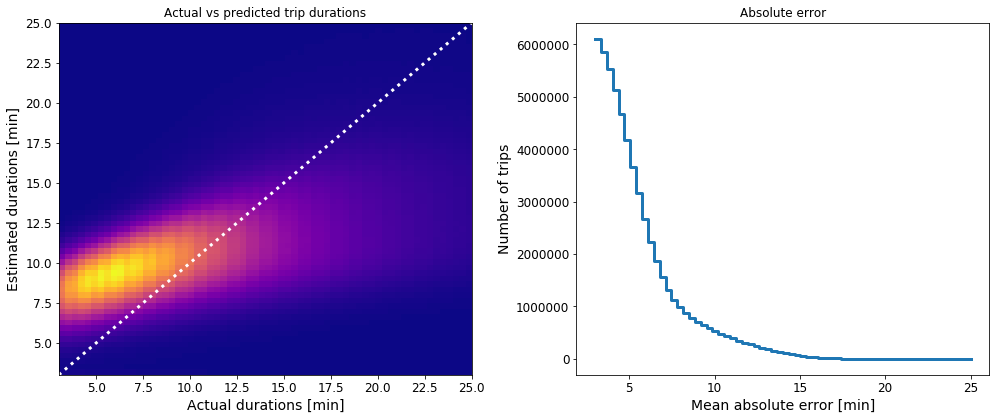

In [27]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
df_test.plot(x='trip_duration_min', y='pred_final', shape=64, limits=[3, 25], colorbar=False, colormap='plasma')
plt.plot([3, 25], [3, 25], color='w', lw=3, ls=':')

plt.title('Actual vs predicted trip durations')
plt.xlabel('Actual durations [min]')
plt.ylabel('Estimated durations [min]')

plt.subplot(122)
df_test['abs_error'] = np.abs(df_test.trip_duration_min - df_test.pred_final)
df_test.plot1d('abs_error', shape=64, lw=3, limits=[3, 25], color='C0')

plt.title('Absolute error')
plt.xlabel('Mean absolute error [min]')
plt.ylabel('Number of trips')

plt.tight_layout()
plt.show()

In [28]:
# See what percentage of the trips durations are predicted with an absolute error less than 5 minutes.
num_abs_err_under_5_min = df_test.count('abs_error', selection='abs_error < 5')
num_trips = len(df_test)
err_perc = num_abs_err_under_5_min / num_trips * 100

print(f'{err_perc:.3}% of the trips durations in the test set were predicted within an absolute error of 5 minutes.')

76.5% of the trips durations in the test set were predicted within an absolute error of 5 minutes.


From the above metrics and diagnostic plots, it looks like there is a lot of room for improvement!

See which features are more valued by the model.

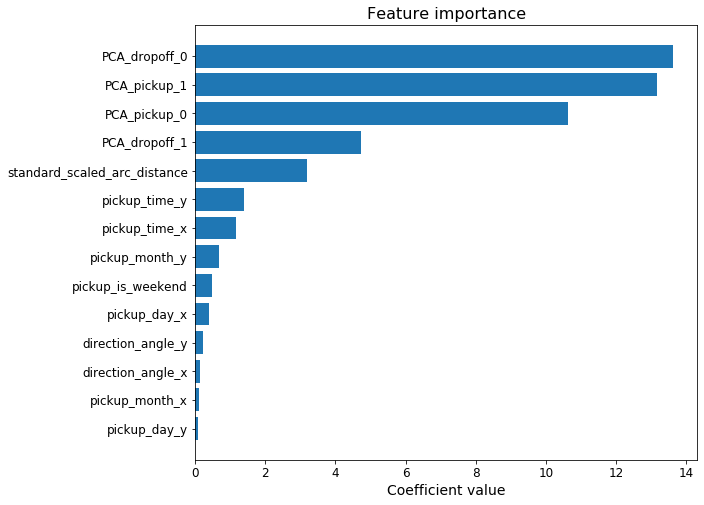

In [29]:
# Feature importance

# Sort indices of the features by their importance 
ind = np.argsort(np.abs(vaex_model.model.coef_))
# Sort the coefficients 
coef_ = np.abs(model.coef_[ind])
# Sort the features
features_ = np.array(features)[ind]

# Plot the feature importance
n_features = len(coef_)

plt.figure(figsize=(9, 8))
plt.barh(y=range(n_features), width=coef_)
plt.yticks(ticks=range(n_features), labels=features_)
plt.title('Feature importance', fontsize=16)
plt.xlabel('Coefficient value')
plt.show()

### What about production?

We can make use of the fact that in `vaex`, a filtered DataFrame actually still contains all the data, plus an expression that defines which rows are filtered out and which are not. While in NumPy or Pandas you can only filter our _more_ rows, in `vaex` you can actually get rows back by using the "or" operator in a filter.

The following is an example on how to you can do exactly this. We add a variable called "production" to the training DataFrame and set its value to `False`. Then we add an additional filter, which in this case is just the value of the variable. However, now we use "or", instead of the default "and" operator which is used when you do e.g. `df3 = df2[df2.x<5]`. The idea is simple: if this last filter is set to `False`, it will have no effect on any other filters since its mode of operation is "or". If it is set to `True` however, by modifying the "production" variable, it will invalidate all other filters, thus any data point can pass through.

This shows another powerful feature of `vaex`: because even filtering is based on expressions, we can build a single flexible "pipeline", instead of multiple explicit pipelines, which are cumbersome to create.

In [30]:
# Add variable name production with its value set to False for the training set
df_train.add_variable('production', False)

# Add an additional filter
df_train = df_train.filter('production', mode='or')

In [31]:
# Again, get the latest state from the training dataset
state = df_train.state_get()
# Apply it to the test set
df_test_prod.state_set(state)
# Immediately change the "production" variable value to "True", before the filters are evaluated
df_test_prod.variables['production'] = True
# Check the length of the test DataFrame in this case
print(f'Number of samples in the test set in "production mode" is {len(df_test_prod):,}.')

Number of samples in the test set in "production mode" is 146,112,990.


Let check the mean absolute error of the test set in this case.

In [32]:
# Calculate the mean absolute error
test_mae_prod = df_test_prod.mean(np.abs(df_test_prod.pred_final - df_test_prod.trip_duration_min))

print(f'The mean absolute error of the test set in "production mode" is {test_mae_prod:.3} minuts.')

The mean absolute error of the test set in "production mode" is 13.3 minuts.


The mean absolute error is much worse in this case. This is expected, since in this case the model is predicting outcomes for cases it was not trained for.

By combining computing capabilities of `vaex` and the on-line models from `scikit-learn`, one can easily create and iterate over models that are trained on billions of samples in a very short amount of time, even on a laptop. The model created in this notebook is far from perfect, but with `vaex` you can efficiently and easily create new features, try different model parameters, and calculate various model diagnostics. How much can you improve on this result?